# 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 디바이스 설정

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)

사용 중인 디바이스: cuda


# 하이퍼파라미터 설정

In [7]:
batch_size = 128
z_dim = 100
lr = 0.0002
epochs = 100

# 데이터 불러오기 및 전처리

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
dataloader = DataLoader(mnist, batch_size = batch_size, shuffle = True)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.89MB/s]


# GAN 아키텍쳐 구현

In [20]:
# Generator : z -> x (28 * 28)
class Generator(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),   # 28*28
            nn.Tanh()              # MNIST는 [-1, 1]로 정규화되었기 때문
        )
  def forward(self, z):
    out = self.net(z)
    return out.view(-1, 1, 28, 28)

# Discriminator: x → [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),   # 성능 향상을 위해
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # 성능 향상을 위해
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x.view(-1, 784)
        return self.net(out)

# 손실함수, 최적화 방법 정의

In [21]:
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

In [22]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 모델 학습

In [12]:
from tqdm import tqdm  # 진행률 표시용

epochs = 100  # 원하는 만큼 조절
g_losses = []
d_losses = []

for epoch in range(1, epochs + 1):
    g_loss_total = 0
    d_loss_total = 0

    for real_imgs, _ in tqdm(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        ### 1. 진짜/가짜 라벨 만들기 ###
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ### 2. ---------------------
        ### Discriminator 학습 단계
        ### -----------------------
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)

        # D가 real과 fake 각각 잘 분별하도록 BCE Loss 계산
        real_preds = discriminator(real_imgs)
        fake_preds = discriminator(fake_imgs.detach())  # detach: G의 그래프에서 분리

        d_loss_real = criterion(real_preds, real_labels)
        d_loss_fake = criterion(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # D 업데이트
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ### 3. ---------------------
        ### Generator 학습 단계
        ### -----------------------
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)

        fake_preds = discriminator(fake_imgs)
        g_loss = criterion(fake_preds, real_labels)  # G는 D를 속이길 원하므로 → real로 착각하게끔

        # G 업데이트
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()

    # 에폭 끝난 뒤 저장
    g_losses.append(g_loss_total / len(dataloader))
    d_losses.append(d_loss_total / len(dataloader))

    print(f"[Epoch {epoch}] D Loss: {d_loss_total / len(dataloader):.4f} | G Loss: {g_loss_total / len(dataloader):.4f}")



100%|██████████| 469/469 [00:15<00:00, 30.56it/s]


[Epoch 1] D Loss: 0.9925 | G Loss: 1.2834


100%|██████████| 469/469 [00:15<00:00, 30.53it/s]


[Epoch 2] D Loss: 0.9952 | G Loss: 1.2938


100%|██████████| 469/469 [00:15<00:00, 30.32it/s]


[Epoch 3] D Loss: 0.9837 | G Loss: 1.3058


100%|██████████| 469/469 [00:14<00:00, 31.69it/s]


[Epoch 4] D Loss: 0.9818 | G Loss: 1.3005


100%|██████████| 469/469 [00:14<00:00, 31.58it/s]


[Epoch 5] D Loss: 0.9756 | G Loss: 1.3184


100%|██████████| 469/469 [00:14<00:00, 31.97it/s]


[Epoch 6] D Loss: 0.9796 | G Loss: 1.3063


100%|██████████| 469/469 [00:14<00:00, 31.80it/s]


[Epoch 7] D Loss: 0.9694 | G Loss: 1.3176


100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


[Epoch 8] D Loss: 0.9711 | G Loss: 1.3249


100%|██████████| 469/469 [00:14<00:00, 31.80it/s]


[Epoch 9] D Loss: 0.9679 | G Loss: 1.3261


100%|██████████| 469/469 [00:15<00:00, 31.20it/s]


[Epoch 10] D Loss: 0.9668 | G Loss: 1.3305


100%|██████████| 469/469 [00:15<00:00, 30.55it/s]


[Epoch 11] D Loss: 0.9620 | G Loss: 1.3313


100%|██████████| 469/469 [00:14<00:00, 31.83it/s]


[Epoch 12] D Loss: 0.9574 | G Loss: 1.3401


100%|██████████| 469/469 [00:14<00:00, 32.07it/s]


[Epoch 13] D Loss: 0.9645 | G Loss: 1.3542


100%|██████████| 469/469 [00:14<00:00, 32.14it/s]


[Epoch 14] D Loss: 0.9474 | G Loss: 1.3476


100%|██████████| 469/469 [00:14<00:00, 31.91it/s]


[Epoch 15] D Loss: 0.9508 | G Loss: 1.3510


100%|██████████| 469/469 [00:14<00:00, 31.66it/s]


[Epoch 16] D Loss: 0.9414 | G Loss: 1.3664


100%|██████████| 469/469 [00:14<00:00, 31.94it/s]


[Epoch 17] D Loss: 0.9332 | G Loss: 1.3789


100%|██████████| 469/469 [00:14<00:00, 31.40it/s]


[Epoch 18] D Loss: 0.9360 | G Loss: 1.3761


100%|██████████| 469/469 [00:15<00:00, 31.03it/s]


[Epoch 19] D Loss: 0.9392 | G Loss: 1.3827


100%|██████████| 469/469 [00:14<00:00, 31.59it/s]


[Epoch 20] D Loss: 0.9288 | G Loss: 1.3911


100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


[Epoch 21] D Loss: 0.9243 | G Loss: 1.4023


100%|██████████| 469/469 [00:14<00:00, 31.96it/s]


[Epoch 22] D Loss: 0.9225 | G Loss: 1.4128


100%|██████████| 469/469 [00:14<00:00, 31.94it/s]


[Epoch 23] D Loss: 0.9250 | G Loss: 1.4122


100%|██████████| 469/469 [00:14<00:00, 31.95it/s]


[Epoch 24] D Loss: 0.9152 | G Loss: 1.4253


100%|██████████| 469/469 [00:14<00:00, 31.87it/s]


[Epoch 25] D Loss: 0.9089 | G Loss: 1.4233


100%|██████████| 469/469 [00:14<00:00, 32.15it/s]


[Epoch 26] D Loss: 0.9129 | G Loss: 1.4361


100%|██████████| 469/469 [00:14<00:00, 31.58it/s]


[Epoch 27] D Loss: 0.9037 | G Loss: 1.4444


100%|██████████| 469/469 [00:14<00:00, 31.33it/s]


[Epoch 28] D Loss: 0.9060 | G Loss: 1.4469


100%|██████████| 469/469 [00:14<00:00, 32.37it/s]


[Epoch 29] D Loss: 0.9030 | G Loss: 1.4449


100%|██████████| 469/469 [00:14<00:00, 31.97it/s]


[Epoch 30] D Loss: 0.8945 | G Loss: 1.4565


100%|██████████| 469/469 [00:14<00:00, 32.21it/s]


[Epoch 31] D Loss: 0.8917 | G Loss: 1.4662


100%|██████████| 469/469 [00:14<00:00, 32.12it/s]


[Epoch 32] D Loss: 0.8830 | G Loss: 1.4639


100%|██████████| 469/469 [00:14<00:00, 32.13it/s]


[Epoch 33] D Loss: 0.8763 | G Loss: 1.4823


100%|██████████| 469/469 [00:14<00:00, 32.17it/s]


[Epoch 34] D Loss: 0.8826 | G Loss: 1.4820


100%|██████████| 469/469 [00:14<00:00, 32.33it/s]


[Epoch 35] D Loss: 0.8659 | G Loss: 1.4936


100%|██████████| 469/469 [00:15<00:00, 30.98it/s]


[Epoch 36] D Loss: 0.8687 | G Loss: 1.5091


100%|██████████| 469/469 [00:15<00:00, 31.12it/s]


[Epoch 37] D Loss: 0.8626 | G Loss: 1.5162


100%|██████████| 469/469 [00:14<00:00, 31.52it/s]


[Epoch 38] D Loss: 0.8520 | G Loss: 1.5278


100%|██████████| 469/469 [00:14<00:00, 31.53it/s]


[Epoch 39] D Loss: 0.8592 | G Loss: 1.5332


100%|██████████| 469/469 [00:14<00:00, 31.76it/s]


[Epoch 40] D Loss: 0.8629 | G Loss: 1.5258


100%|██████████| 469/469 [00:14<00:00, 31.90it/s]


[Epoch 41] D Loss: 0.8614 | G Loss: 1.5262


100%|██████████| 469/469 [00:14<00:00, 31.77it/s]


[Epoch 42] D Loss: 0.8498 | G Loss: 1.5348


100%|██████████| 469/469 [00:14<00:00, 31.96it/s]


[Epoch 43] D Loss: 0.8501 | G Loss: 1.5453


100%|██████████| 469/469 [00:15<00:00, 30.60it/s]


[Epoch 44] D Loss: 0.8482 | G Loss: 1.5630


100%|██████████| 469/469 [00:15<00:00, 31.17it/s]


[Epoch 45] D Loss: 0.8490 | G Loss: 1.5543


100%|██████████| 469/469 [00:14<00:00, 31.86it/s]


[Epoch 46] D Loss: 0.8449 | G Loss: 1.5583


100%|██████████| 469/469 [00:14<00:00, 32.13it/s]


[Epoch 47] D Loss: 0.8353 | G Loss: 1.5704


100%|██████████| 469/469 [00:14<00:00, 32.28it/s]


[Epoch 48] D Loss: 0.8416 | G Loss: 1.5748


100%|██████████| 469/469 [00:14<00:00, 32.34it/s]


[Epoch 49] D Loss: 0.8407 | G Loss: 1.5699


100%|██████████| 469/469 [00:14<00:00, 32.16it/s]


[Epoch 50] D Loss: 0.8389 | G Loss: 1.5790


100%|██████████| 469/469 [00:14<00:00, 32.06it/s]


[Epoch 51] D Loss: 0.8368 | G Loss: 1.5860


100%|██████████| 469/469 [00:14<00:00, 31.85it/s]


[Epoch 52] D Loss: 0.8365 | G Loss: 1.5904


100%|██████████| 469/469 [00:15<00:00, 31.08it/s]


[Epoch 53] D Loss: 0.8356 | G Loss: 1.5911


100%|██████████| 469/469 [00:15<00:00, 31.11it/s]


[Epoch 54] D Loss: 0.8446 | G Loss: 1.5949


100%|██████████| 469/469 [00:14<00:00, 32.28it/s]


[Epoch 55] D Loss: 0.8358 | G Loss: 1.5950


100%|██████████| 469/469 [00:14<00:00, 32.31it/s]


[Epoch 56] D Loss: 0.8335 | G Loss: 1.5990


100%|██████████| 469/469 [00:14<00:00, 31.93it/s]


[Epoch 57] D Loss: 0.8281 | G Loss: 1.6006


100%|██████████| 469/469 [00:14<00:00, 32.20it/s]


[Epoch 58] D Loss: 0.8236 | G Loss: 1.6075


100%|██████████| 469/469 [00:14<00:00, 32.25it/s]


[Epoch 59] D Loss: 0.8207 | G Loss: 1.6263


100%|██████████| 469/469 [00:14<00:00, 32.26it/s]


[Epoch 60] D Loss: 0.8166 | G Loss: 1.6141


100%|██████████| 469/469 [00:14<00:00, 32.07it/s]


[Epoch 61] D Loss: 0.8202 | G Loss: 1.6272


100%|██████████| 469/469 [00:15<00:00, 31.17it/s]


[Epoch 62] D Loss: 0.8232 | G Loss: 1.6251


100%|██████████| 469/469 [00:14<00:00, 31.66it/s]


[Epoch 63] D Loss: 0.8134 | G Loss: 1.6329


100%|██████████| 469/469 [00:14<00:00, 32.47it/s]


[Epoch 64] D Loss: 0.8150 | G Loss: 1.6248


100%|██████████| 469/469 [00:14<00:00, 32.28it/s]


[Epoch 65] D Loss: 0.8139 | G Loss: 1.6311


100%|██████████| 469/469 [00:14<00:00, 32.31it/s]


[Epoch 66] D Loss: 0.8127 | G Loss: 1.6403


100%|██████████| 469/469 [00:14<00:00, 31.51it/s]


[Epoch 67] D Loss: 0.8127 | G Loss: 1.6392


100%|██████████| 469/469 [00:14<00:00, 31.75it/s]


[Epoch 68] D Loss: 0.8060 | G Loss: 1.6440


100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


[Epoch 69] D Loss: 0.8174 | G Loss: 1.6463


100%|██████████| 469/469 [00:15<00:00, 31.20it/s]


[Epoch 70] D Loss: 0.8051 | G Loss: 1.6497


100%|██████████| 469/469 [00:15<00:00, 29.67it/s]


[Epoch 71] D Loss: 0.8141 | G Loss: 1.6481


100%|██████████| 469/469 [00:15<00:00, 31.23it/s]


[Epoch 72] D Loss: 0.8056 | G Loss: 1.6538


100%|██████████| 469/469 [00:14<00:00, 31.29it/s]


[Epoch 73] D Loss: 0.8065 | G Loss: 1.6605


100%|██████████| 469/469 [00:15<00:00, 30.86it/s]


[Epoch 74] D Loss: 0.8012 | G Loss: 1.6662


100%|██████████| 469/469 [00:14<00:00, 31.43it/s]


[Epoch 75] D Loss: 0.8050 | G Loss: 1.6656


100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


[Epoch 76] D Loss: 0.8057 | G Loss: 1.6744


100%|██████████| 469/469 [00:14<00:00, 31.75it/s]


[Epoch 77] D Loss: 0.8032 | G Loss: 1.6732


100%|██████████| 469/469 [00:15<00:00, 31.14it/s]


[Epoch 78] D Loss: 0.8057 | G Loss: 1.6702


100%|██████████| 469/469 [00:15<00:00, 31.13it/s]


[Epoch 79] D Loss: 0.7963 | G Loss: 1.6678


100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


[Epoch 80] D Loss: 0.8012 | G Loss: 1.6715


100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


[Epoch 81] D Loss: 0.8001 | G Loss: 1.6801


100%|██████████| 469/469 [00:14<00:00, 31.97it/s]


[Epoch 82] D Loss: 0.7915 | G Loss: 1.6829


100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


[Epoch 83] D Loss: 0.7976 | G Loss: 1.6834


100%|██████████| 469/469 [00:14<00:00, 32.21it/s]


[Epoch 84] D Loss: 0.7926 | G Loss: 1.6849


100%|██████████| 469/469 [00:14<00:00, 32.10it/s]


[Epoch 85] D Loss: 0.7895 | G Loss: 1.6816


100%|██████████| 469/469 [00:14<00:00, 31.69it/s]


[Epoch 86] D Loss: 0.7942 | G Loss: 1.6940


100%|██████████| 469/469 [00:15<00:00, 30.49it/s]


[Epoch 87] D Loss: 0.7936 | G Loss: 1.6884


100%|██████████| 469/469 [00:14<00:00, 31.82it/s]


[Epoch 88] D Loss: 0.7899 | G Loss: 1.6882


100%|██████████| 469/469 [00:14<00:00, 32.23it/s]


[Epoch 89] D Loss: 0.7853 | G Loss: 1.6955


100%|██████████| 469/469 [00:14<00:00, 31.48it/s]


[Epoch 90] D Loss: 0.7866 | G Loss: 1.7033


100%|██████████| 469/469 [00:14<00:00, 31.90it/s]


[Epoch 91] D Loss: 0.7818 | G Loss: 1.7053


100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


[Epoch 92] D Loss: 0.7854 | G Loss: 1.7158


100%|██████████| 469/469 [00:14<00:00, 32.02it/s]


[Epoch 93] D Loss: 0.7877 | G Loss: 1.7163


100%|██████████| 469/469 [00:14<00:00, 31.67it/s]


[Epoch 94] D Loss: 0.7808 | G Loss: 1.7110


100%|██████████| 469/469 [00:15<00:00, 31.13it/s]


[Epoch 95] D Loss: 0.7810 | G Loss: 1.7136


100%|██████████| 469/469 [00:15<00:00, 31.21it/s]


[Epoch 96] D Loss: 0.7836 | G Loss: 1.7282


100%|██████████| 469/469 [00:14<00:00, 32.09it/s]


[Epoch 97] D Loss: 0.7775 | G Loss: 1.7319


100%|██████████| 469/469 [00:14<00:00, 31.77it/s]


[Epoch 98] D Loss: 0.7725 | G Loss: 1.7268


100%|██████████| 469/469 [00:14<00:00, 31.98it/s]


[Epoch 99] D Loss: 0.7738 | G Loss: 1.7316


100%|██████████| 469/469 [00:14<00:00, 31.86it/s]

[Epoch 100] D Loss: 0.7687 | G Loss: 1.7330


# Loss 시각화

In [13]:
def plot_gan_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss", color='blue')
    plt.plot(d_losses, label="Discriminator Loss", color='red')
    plt.title("GAN Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


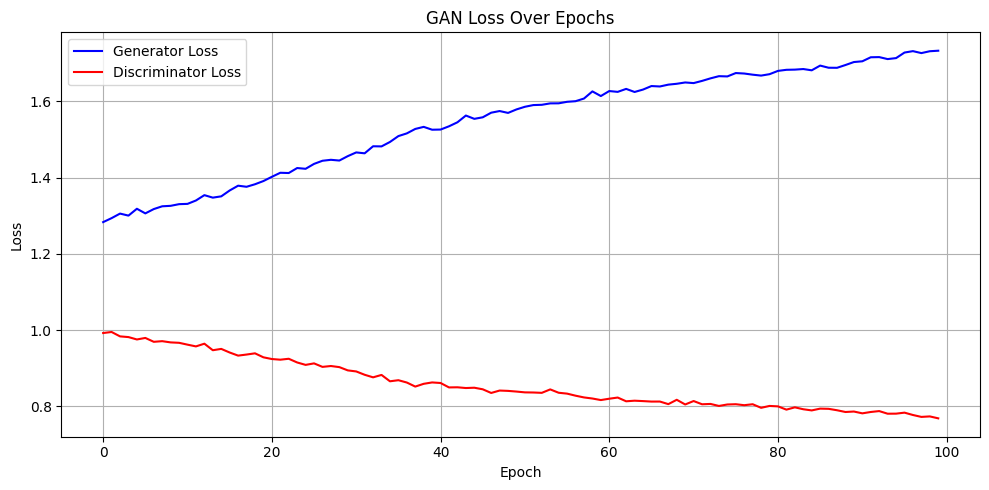

In [14]:
plot_gan_losses(g_losses, d_losses)


# 생성 이미지 시각화

In [15]:
import torchvision.utils as vutils

# 시각화를 위한 고정된 z (재현성 유지)
fixed_z = torch.randn(64, z_dim).to(device)

def show_generated_images(generator, epoch=None):
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(fixed_z).detach().cpu()
    generator.train()

    # 이미지 [-1, 1] → [0, 1]로 복구
    fake_imgs = (fake_imgs + 1) / 2

    grid = vutils.make_grid(fake_imgs, nrow=8, padding=2, normalize=False)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    title = f"Generated Images (Epoch {epoch})" if epoch else "Generated Images"
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()


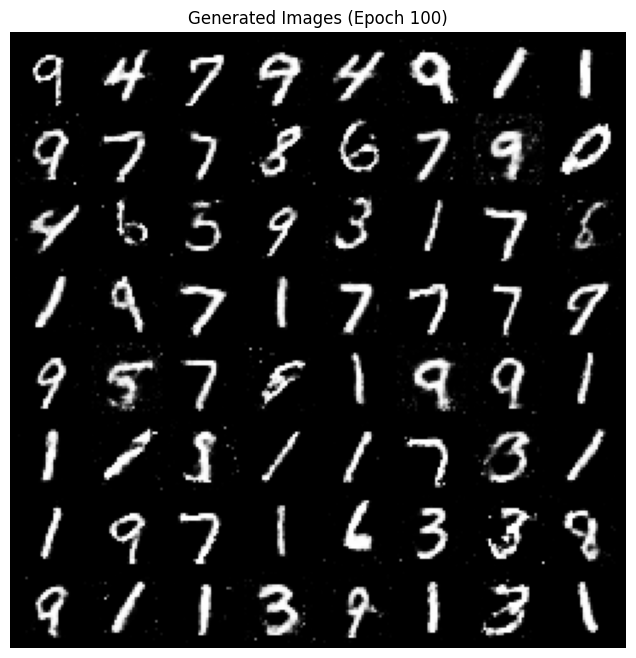

In [16]:
show_generated_images(generator, epoch=epochs)

# 학습 성능 향상시키기

100%|██████████| 469/469 [00:15<00:00, 30.88it/s]


[Epoch 1] D Loss: 0.9011 | G Loss: 1.4984


100%|██████████| 469/469 [00:16<00:00, 28.59it/s]


[Epoch 2] D Loss: 0.6295 | G Loss: 2.7125


100%|██████████| 469/469 [00:15<00:00, 29.81it/s]


[Epoch 3] D Loss: 0.6175 | G Loss: 3.1299


100%|██████████| 469/469 [00:15<00:00, 30.87it/s]


[Epoch 4] D Loss: 0.6018 | G Loss: 3.2422


100%|██████████| 469/469 [00:15<00:00, 31.25it/s]


[Epoch 5] D Loss: 0.5871 | G Loss: 3.4171


100%|██████████| 469/469 [00:15<00:00, 30.55it/s]


[Epoch 6] D Loss: 0.6144 | G Loss: 3.0162


100%|██████████| 469/469 [00:15<00:00, 30.62it/s]


[Epoch 7] D Loss: 0.6696 | G Loss: 2.7864


100%|██████████| 469/469 [00:16<00:00, 29.26it/s]


[Epoch 8] D Loss: 0.6939 | G Loss: 2.6349


100%|██████████| 469/469 [00:16<00:00, 28.59it/s]


[Epoch 9] D Loss: 0.7948 | G Loss: 2.2143


100%|██████████| 469/469 [00:15<00:00, 30.31it/s]


[Epoch 10] D Loss: 0.8330 | G Loss: 2.0507


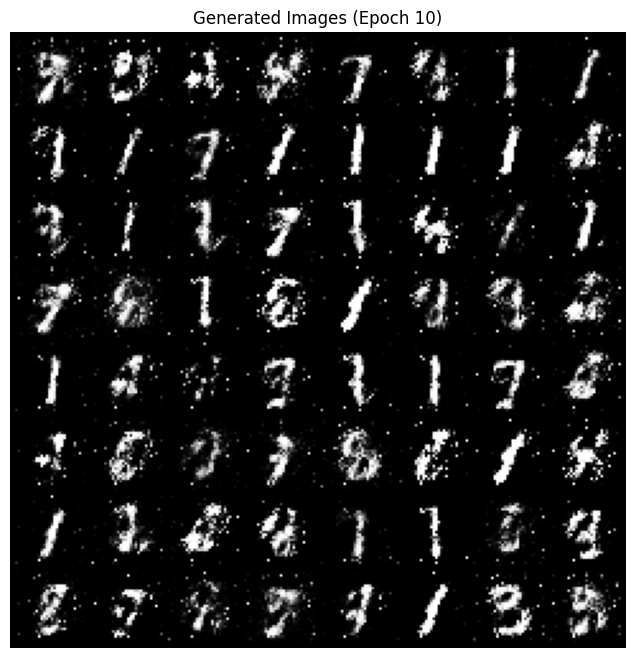

100%|██████████| 469/469 [00:15<00:00, 29.88it/s]


[Epoch 11] D Loss: 0.8571 | G Loss: 1.9706


100%|██████████| 469/469 [00:15<00:00, 30.02it/s]


[Epoch 12] D Loss: 0.8945 | G Loss: 1.8413


100%|██████████| 469/469 [00:15<00:00, 29.59it/s]


[Epoch 13] D Loss: 0.9286 | G Loss: 1.7239


100%|██████████| 469/469 [00:16<00:00, 28.29it/s]


[Epoch 14] D Loss: 0.9351 | G Loss: 1.6871


100%|██████████| 469/469 [00:15<00:00, 29.60it/s]


[Epoch 15] D Loss: 0.9601 | G Loss: 1.6359


100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


[Epoch 16] D Loss: 0.9992 | G Loss: 1.5258


100%|██████████| 469/469 [00:15<00:00, 29.70it/s]


[Epoch 17] D Loss: 0.9974 | G Loss: 1.5066


100%|██████████| 469/469 [00:15<00:00, 30.00it/s]


[Epoch 18] D Loss: 0.9966 | G Loss: 1.4979


100%|██████████| 469/469 [00:16<00:00, 28.55it/s]


[Epoch 19] D Loss: 1.0186 | G Loss: 1.4507


100%|██████████| 469/469 [00:15<00:00, 29.69it/s]


[Epoch 20] D Loss: 1.0268 | G Loss: 1.4262


100%|██████████| 469/469 [00:15<00:00, 29.96it/s]


[Epoch 21] D Loss: 1.0469 | G Loss: 1.3908


100%|██████████| 469/469 [00:15<00:00, 29.90it/s]


[Epoch 22] D Loss: 1.0591 | G Loss: 1.3559


100%|██████████| 469/469 [00:15<00:00, 29.77it/s]


[Epoch 23] D Loss: 1.0650 | G Loss: 1.3413


100%|██████████| 469/469 [00:16<00:00, 28.81it/s]


[Epoch 24] D Loss: 1.0702 | G Loss: 1.3355


100%|██████████| 469/469 [00:16<00:00, 28.87it/s]


[Epoch 25] D Loss: 1.0881 | G Loss: 1.3012


100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


[Epoch 26] D Loss: 1.0963 | G Loss: 1.2865


100%|██████████| 469/469 [00:15<00:00, 29.53it/s]


[Epoch 27] D Loss: 1.1000 | G Loss: 1.2784


100%|██████████| 469/469 [00:15<00:00, 29.95it/s]


[Epoch 28] D Loss: 1.1050 | G Loss: 1.2624


100%|██████████| 469/469 [00:16<00:00, 29.12it/s]


[Epoch 29] D Loss: 1.1114 | G Loss: 1.2551


100%|██████████| 469/469 [00:16<00:00, 28.94it/s]


[Epoch 30] D Loss: 1.1256 | G Loss: 1.2325


100%|██████████| 469/469 [00:15<00:00, 30.04it/s]


[Epoch 31] D Loss: 1.1308 | G Loss: 1.2154


100%|██████████| 469/469 [00:15<00:00, 29.86it/s]


[Epoch 32] D Loss: 1.1309 | G Loss: 1.2112


100%|██████████| 469/469 [00:15<00:00, 30.11it/s]


[Epoch 33] D Loss: 1.1401 | G Loss: 1.2006


100%|██████████| 469/469 [00:15<00:00, 29.61it/s]


[Epoch 34] D Loss: 1.1541 | G Loss: 1.1726


100%|██████████| 469/469 [00:16<00:00, 28.19it/s]


[Epoch 35] D Loss: 1.1520 | G Loss: 1.1787


100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


[Epoch 36] D Loss: 1.1517 | G Loss: 1.1792


100%|██████████| 469/469 [00:15<00:00, 30.00it/s]


[Epoch 37] D Loss: 1.1587 | G Loss: 1.1654


100%|██████████| 469/469 [00:15<00:00, 29.86it/s]


[Epoch 38] D Loss: 1.1630 | G Loss: 1.1581


100%|██████████| 469/469 [00:15<00:00, 30.05it/s]


[Epoch 39] D Loss: 1.1665 | G Loss: 1.1563


100%|██████████| 469/469 [00:16<00:00, 27.82it/s]


[Epoch 40] D Loss: 1.1693 | G Loss: 1.1466


100%|██████████| 469/469 [00:16<00:00, 28.86it/s]


[Epoch 41] D Loss: 1.1762 | G Loss: 1.1364


100%|██████████| 469/469 [00:15<00:00, 29.33it/s]


[Epoch 42] D Loss: 1.1786 | G Loss: 1.1367


100%|██████████| 469/469 [00:15<00:00, 29.61it/s]


[Epoch 43] D Loss: 1.1845 | G Loss: 1.1244


100%|██████████| 469/469 [00:16<00:00, 29.29it/s]


[Epoch 44] D Loss: 1.1840 | G Loss: 1.1198


100%|██████████| 469/469 [00:16<00:00, 27.72it/s]


[Epoch 45] D Loss: 1.1883 | G Loss: 1.1085


100%|██████████| 469/469 [00:15<00:00, 29.56it/s]


[Epoch 46] D Loss: 1.1942 | G Loss: 1.1102


100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


[Epoch 47] D Loss: 1.1963 | G Loss: 1.1008


100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


[Epoch 48] D Loss: 1.1958 | G Loss: 1.1025


100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


[Epoch 49] D Loss: 1.1957 | G Loss: 1.1000


100%|██████████| 469/469 [00:16<00:00, 28.12it/s]


[Epoch 50] D Loss: 1.1983 | G Loss: 1.0974


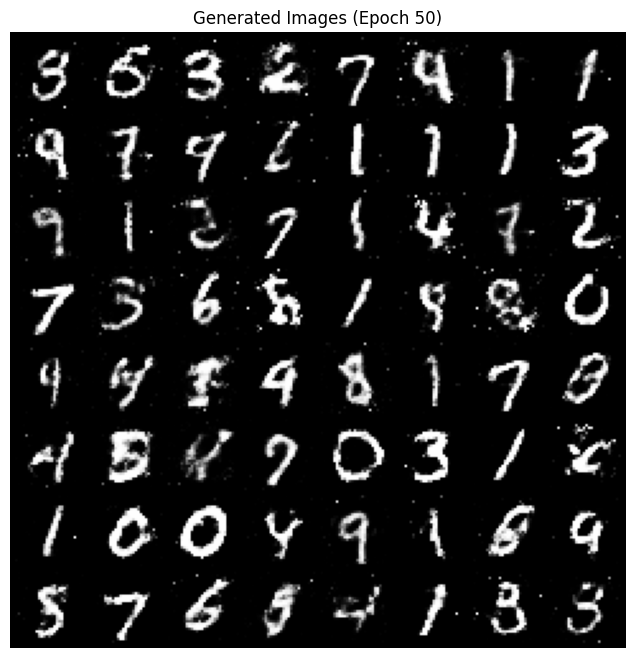

100%|██████████| 469/469 [00:15<00:00, 29.91it/s]


[Epoch 51] D Loss: 1.1966 | G Loss: 1.1028


100%|██████████| 469/469 [00:15<00:00, 29.70it/s]


[Epoch 52] D Loss: 1.1942 | G Loss: 1.1027


100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


[Epoch 53] D Loss: 1.1997 | G Loss: 1.0897


100%|██████████| 469/469 [00:15<00:00, 29.62it/s]


[Epoch 54] D Loss: 1.2002 | G Loss: 1.0938


100%|██████████| 469/469 [00:16<00:00, 28.15it/s]


[Epoch 55] D Loss: 1.2041 | G Loss: 1.0846


100%|██████████| 469/469 [00:16<00:00, 29.06it/s]


[Epoch 56] D Loss: 1.2043 | G Loss: 1.0875


100%|██████████| 469/469 [00:16<00:00, 29.09it/s]


[Epoch 57] D Loss: 1.2096 | G Loss: 1.0844


100%|██████████| 469/469 [00:15<00:00, 29.82it/s]


[Epoch 58] D Loss: 1.2099 | G Loss: 1.0726


100%|██████████| 469/469 [00:15<00:00, 29.67it/s]


[Epoch 59] D Loss: 1.2072 | G Loss: 1.0746


100%|██████████| 469/469 [00:16<00:00, 28.66it/s]


[Epoch 60] D Loss: 1.2097 | G Loss: 1.0758


100%|██████████| 469/469 [00:16<00:00, 28.94it/s]


[Epoch 61] D Loss: 1.2124 | G Loss: 1.0701


100%|██████████| 469/469 [00:15<00:00, 29.53it/s]


[Epoch 62] D Loss: 1.2150 | G Loss: 1.0703


100%|██████████| 469/469 [00:15<00:00, 29.63it/s]


[Epoch 63] D Loss: 1.2120 | G Loss: 1.0707


100%|██████████| 469/469 [00:15<00:00, 29.44it/s]


[Epoch 64] D Loss: 1.2142 | G Loss: 1.0660


100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


[Epoch 65] D Loss: 1.2153 | G Loss: 1.0640


100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


[Epoch 66] D Loss: 1.2159 | G Loss: 1.0630


100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


[Epoch 67] D Loss: 1.2135 | G Loss: 1.0676


100%|██████████| 469/469 [00:16<00:00, 29.29it/s]


[Epoch 68] D Loss: 1.2188 | G Loss: 1.0616


100%|██████████| 469/469 [00:16<00:00, 29.26it/s]


[Epoch 69] D Loss: 1.2195 | G Loss: 1.0578


100%|██████████| 469/469 [00:16<00:00, 28.68it/s]


[Epoch 70] D Loss: 1.2196 | G Loss: 1.0616


100%|██████████| 469/469 [00:16<00:00, 28.37it/s]


[Epoch 71] D Loss: 1.2199 | G Loss: 1.0580


100%|██████████| 469/469 [00:15<00:00, 29.59it/s]


[Epoch 72] D Loss: 1.2197 | G Loss: 1.0550


100%|██████████| 469/469 [00:15<00:00, 29.56it/s]


[Epoch 73] D Loss: 1.2154 | G Loss: 1.0569


100%|██████████| 469/469 [00:15<00:00, 29.54it/s]


[Epoch 74] D Loss: 1.2197 | G Loss: 1.0531


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[Epoch 75] D Loss: 1.2193 | G Loss: 1.0519


100%|██████████| 469/469 [00:16<00:00, 28.38it/s]


[Epoch 76] D Loss: 1.2184 | G Loss: 1.0560


100%|██████████| 469/469 [00:15<00:00, 29.72it/s]


[Epoch 77] D Loss: 1.2200 | G Loss: 1.0536


100%|██████████| 469/469 [00:15<00:00, 29.87it/s]


[Epoch 78] D Loss: 1.2177 | G Loss: 1.0534


100%|██████████| 469/469 [00:15<00:00, 29.81it/s]


[Epoch 79] D Loss: 1.2180 | G Loss: 1.0500


100%|██████████| 469/469 [00:15<00:00, 29.51it/s]


[Epoch 80] D Loss: 1.2195 | G Loss: 1.0534


100%|██████████| 469/469 [00:16<00:00, 28.34it/s]


[Epoch 81] D Loss: 1.2198 | G Loss: 1.0531


100%|██████████| 469/469 [00:15<00:00, 29.71it/s]


[Epoch 82] D Loss: 1.2242 | G Loss: 1.0453


100%|██████████| 469/469 [00:15<00:00, 29.68it/s]


[Epoch 83] D Loss: 1.2225 | G Loss: 1.0473


100%|██████████| 469/469 [00:15<00:00, 29.46it/s]


[Epoch 84] D Loss: 1.2233 | G Loss: 1.0476


100%|██████████| 469/469 [00:15<00:00, 29.66it/s]


[Epoch 85] D Loss: 1.2235 | G Loss: 1.0401


100%|██████████| 469/469 [00:16<00:00, 28.20it/s]


[Epoch 86] D Loss: 1.2246 | G Loss: 1.0488


100%|██████████| 469/469 [00:16<00:00, 29.27it/s]


[Epoch 87] D Loss: 1.2237 | G Loss: 1.0434


100%|██████████| 469/469 [00:15<00:00, 29.65it/s]


[Epoch 88] D Loss: 1.2252 | G Loss: 1.0470


100%|██████████| 469/469 [00:15<00:00, 29.66it/s]


[Epoch 89] D Loss: 1.2257 | G Loss: 1.0437


100%|██████████| 469/469 [00:15<00:00, 29.58it/s]


[Epoch 90] D Loss: 1.2270 | G Loss: 1.0414


100%|██████████| 469/469 [00:16<00:00, 28.69it/s]


[Epoch 91] D Loss: 1.2275 | G Loss: 1.0376


100%|██████████| 469/469 [00:16<00:00, 29.14it/s]


[Epoch 92] D Loss: 1.2267 | G Loss: 1.0411


100%|██████████| 469/469 [00:15<00:00, 29.98it/s]


[Epoch 93] D Loss: 1.2279 | G Loss: 1.0412


100%|██████████| 469/469 [00:15<00:00, 29.82it/s]


[Epoch 94] D Loss: 1.2297 | G Loss: 1.0357


100%|██████████| 469/469 [00:15<00:00, 29.75it/s]


[Epoch 95] D Loss: 1.2295 | G Loss: 1.0352


100%|██████████| 469/469 [00:15<00:00, 29.35it/s]


[Epoch 96] D Loss: 1.2294 | G Loss: 1.0310


100%|██████████| 469/469 [00:16<00:00, 28.56it/s]


[Epoch 97] D Loss: 1.2305 | G Loss: 1.0372


100%|██████████| 469/469 [00:15<00:00, 29.39it/s]


[Epoch 98] D Loss: 1.2289 | G Loss: 1.0346


100%|██████████| 469/469 [00:16<00:00, 29.22it/s]


[Epoch 99] D Loss: 1.2331 | G Loss: 1.0358


100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


[Epoch 100] D Loss: 1.2308 | G Loss: 1.0292


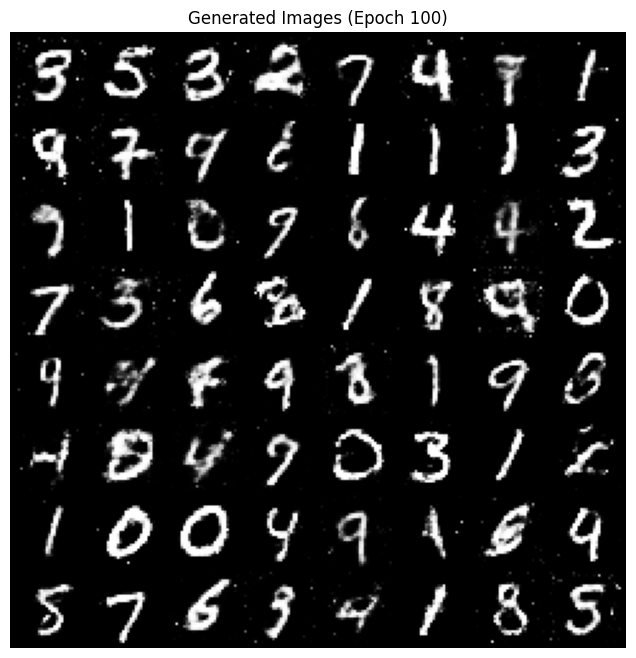

In [23]:
from tqdm import tqdm  # 진행률 표시용

epochs = 100  # 원하는 만큼 조절
g_losses = []
d_losses = []

for epoch in range(1, epochs + 1):
    g_loss_total = 0
    d_loss_total = 0

    for real_imgs, _ in tqdm(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        ### 1. 진짜/가짜 라벨 만들기 ###
        real_labels = torch.full((batch_size, 1), 0.9).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ### 2. ---------------------
        ### Discriminator 학습 단계
        ### -----------------------
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)

        # D가 real과 fake 각각 잘 분별하도록 BCE Loss 계산
        real_preds = discriminator(real_imgs)
        fake_preds = discriminator(fake_imgs.detach())  # detach: G의 그래프에서 분리

        d_loss_real = criterion(real_preds, real_labels)
        d_loss_fake = criterion(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # D 업데이트
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ### 3. ---------------------
        ### Generator 학습 단계
        ### -----------------------
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)

        fake_preds = discriminator(fake_imgs)
        g_loss = criterion(fake_preds, real_labels)  # G는 D를 속이길 원하므로 → real로 착각하게끔

        # G 업데이트
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()

    # 에폭 끝난 뒤 저장
    g_losses.append(g_loss_total / len(dataloader))
    d_losses.append(d_loss_total / len(dataloader))

    print(f"[Epoch {epoch}] D Loss: {d_loss_total / len(dataloader):.4f} | G Loss: {g_loss_total / len(dataloader):.4f}")
    if epoch in [10, 50, 100]:
      show_generated_images(generator, epoch)



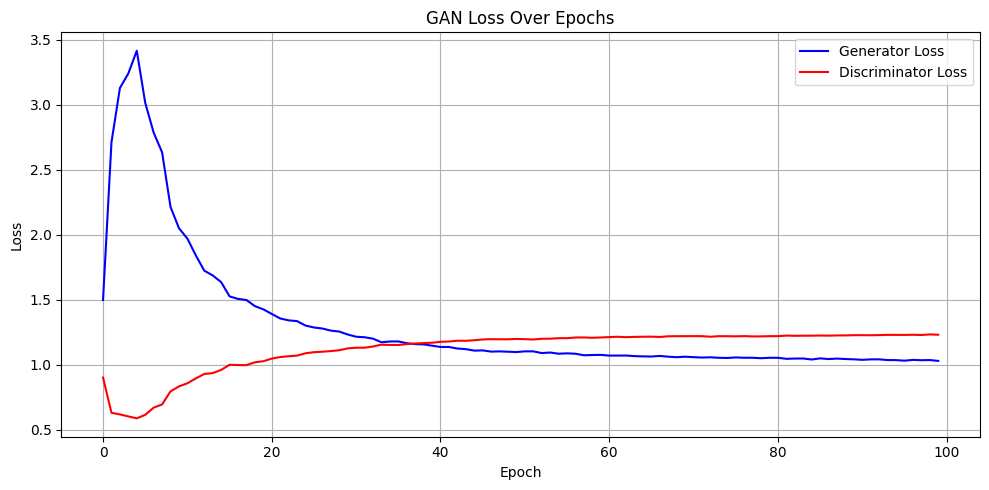

In [24]:
plot_gan_losses(g_losses, d_losses)